Train and score a boosted decision tree model using [LightGBM Python package](https://github.com/Microsoft/LightGBM) from Microsoft, which is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms.  

In [1]:
import os
import sys
import math
import itertools
import datetime
import random
import numpy as np
import pandas as pd
import lightgbm as lgb 
from sklearn.model_selection import train_test_split

In [2]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

from common.metrics import MAPE
import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [3]:
# Data paths
DATA_DIR = '../../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Parameters of GBM model
params = {
    'num_leaves': 50, 
    'objective': 'mape', 
    'min_data_in_leaf': 200, 
    'learning_rate': 0.002, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'num_threads': 16,
    'early_stopping_rounds': 125,
    'verbose_eval': 20
}
# Note that 800 boost rounds is used in this notebook. After checking the training 
# and validation MAPEs, this number is set to be 400 in the submission script.
MAX_ROUNDS = 800 #400 #100 

# Lags and categorical features
lags = [2,3,4] 
categ_fea = ['store', 'brand', 'deal', 'feat'] 

In [4]:
# Utility functions
def week_of_month(dt):
    """Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """ 
    from math import ceil
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom/7.0))
    return wom

def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def lagged_features(df, lags):
    """Create lagged features based on time series data.
    
    Args:
        df (Dataframe): Input time series data sorted by time
        lags (List): Lag lengths
        
    Returns:
        fea (Dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + '_lag' + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea

def moving_averages(df, start_step, window_size=None):
    """Compute averages of every feature over moving time windows.
    
    Args:
        df (Dataframe): Input features as a dataframe
    
    Returns:
        fea (Dataframe): Dataframe consisting of the moving averages
    """
    if window_size == None: # Use a large window to compute average over all historical data
        window_size = df.shape[0]
    fea = df.shift(start_step).rolling(min_periods=1, center=False, window=window_size).mean()
    fea.columns = fea.columns + '_mean'
    return fea

def create_features(df, lags):
    """Create features used for model training.
    
    Args:
        df (Dataframe): Time series data of a certain store and brand
        lags (List): Lag lengths
    
    Returns:
        fea_all (Dataframe): All features for the specific store and brand
    """
    lagged_fea = lagged_features(df[['move']], lags)
    moving_avg = moving_averages(df[['move']], 2, 10)
    fea_columns = ['brand' , 'store', 'week', 'week_of_month', 'day', 'profit', 'deal' , 'feat', 'move']
    #fea_columns = fea_columns + ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']
    fea_all = pd.concat([df[fea_columns], lagged_fea, moving_avg], axis=1)
    return fea_all

def make_predictions(df, model):
    """Predict sales with the trained GBM model.
    
    Args: 
        df (Dataframe): Dataframe including all needed features
        model (Model): Trained GBM model
        
    Returns:
        Dataframe including the predicted sales of a certain store and brand
    """
    predictions = pd.DataFrame({'move': model.predict(df.drop('move', axis=1))})
    predictions['move'] = predictions['move'].apply(lambda x: round(x))
    return pd.concat([df[['brand', 'store', 'week']].reset_index(drop=True), predictions], axis=1)

def evaluate(result):
    """Compute MAPE value of the forecast.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
    
    Returns:
        MAPE value of the forecast
    """
    return MAPE(result['move'], result['actual'])*100

def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store==store) & (results.brand==brand)]
    subset = subset[['week', 'move', 'actual']].set_index('week')
    #print(subset)
    print('Sample MAPE is {}'.format(evaluate(subset)))
    plt.figure()
    ax = subset.plot()
    ax.set_ylim(bottom=0)
    ax.legend(labels=['predicted', 'actual'])

In [5]:
# Train and predict for all forecast rounds
pred_all = []
combined_all = []
metric_all = []
for r in range(bs.NUM_ROUNDS): 
    print('---- Round ' + str(r+1) + ' ----')
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
    train_df['move'] = train_df['logmove'].apply(lambda x: round(math.exp(x)))
    train_df.drop('logmove', axis=1, inplace=True)
    print(train_df.head(3))
    print('')
    # Fill missing values
    store_list = train_df['store'].unique()
    brand_list = train_df['brand'].unique()
    week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r]+1)
    d = {'store': store_list,
         'brand': brand_list,
         'week': week_list}        
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how='left', 
                            on=['store', 'brand', 'week'])
    print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    print('')
    data_filled = data_filled.groupby(['store', 'brand']). \
                              apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    # Create datetime features
    data_filled['week_start'] = data_filled['week'].apply(lambda x: bs.FIRST_WEEK_START + datetime.timedelta(days=(x-bs.TRAIN_START_WEEK)*7))
    data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled['month'] = data_filled['week_start'].apply(lambda x: x.month)
    data_filled['week_of_month'] = data_filled['week_start'].apply(lambda x: week_of_month(x))
    data_filled['day'] = data_filled['week_start'].apply(lambda x: x.day)
    data_filled.drop('week_start', axis=1, inplace=True)
    # Create other features (lagged features, moving averages, etc.)
    features = data_filled.groupby(['store','brand']). \
                           apply(lambda x: create_features(x, lags))
    train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
    print('Maximum training week number is {}'.format(max(train_fea['week'])))
    print('')
    # Drop rows with NaN values
    train_fea.dropna(inplace=True)
    print(train_fea.head(1))
    print('')
    print('Training and predicting models...')
    evals_result = {} # to record eval results for plotting
    # Create a training/validation split
    train_fea, valid_fea, train_label, valid_label = train_test_split(train_fea.drop('move', axis=1, inplace=False), \
                                                                  train_fea['move'], test_size=0.2, random_state=1)
    dtrain = lgb.Dataset(train_fea, train_label)
    dvalid = lgb.Dataset(valid_fea, valid_label)
    # Train GBM model
    bst = lgb.train(
        params, 
        dtrain, 
        num_boost_round = MAX_ROUNDS,
        valid_sets = [dtrain, dvalid], 
        categorical_feature = categ_fea, 
        evals_result = evals_result
    )
    # Generate forecasts
    test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    pred = make_predictions(test_fea, bst). \
           sort_values(by=['store','brand', 'week']). \
           reset_index(drop=True)
    # Additional columns required by the submission format
    pred['round'] = r+1
    pred['weeks_ahead'] = pred['week'] - bs.TRAIN_END_WEEK_LIST[r]
    print(pred)
    print('')
    # Evaluate prediction accuracy
    test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
    test_df['actual'] = test_df['logmove'].apply(lambda x: round(math.exp(x)))
    test_df.drop('logmove', axis=1, inplace=True)
    combined = pd.merge(pred, test_df, on=['store', 'brand', 'week'], how='left')
    metric_value = evaluate(combined)
    print('')
    print('MAPE of current round is {}'.format(metric_value))
    print('')
    # Keep the predictions and accuracy
    pred_all.append(pred)
    combined_all.append(combined)
    metric_all.append(metric_value)

# Generate submission
submission = pd.concat(pred_all, axis=0)
submission.rename(columns={'move': 'prediction'}, inplace=True)
submission = submission[['round', 'store', 'brand', 'week', 'weeks_ahead', 'prediction']]
#submission.to_csv('submission.csv', index=False)

---- Round 1 ----
   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6204

Maximum training week number is 135

   brand  store  week  week_of_month  day     profit  deal  feat    move  \
4      1      2    44              2    5  37.992326   1.0   0.0  8256.0   

   move_lag2  move_lag3  

/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['brand', 'deal', 'feat', 'store']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[2]	training's mape: 0.779224	valid_1's mape: 0.774266
[3]	training's mape: 0.778224	valid_1's mape: 0.773277
[4]	training's mape: 0.777318	valid_1's mape: 0.772399
[5]	training's mape: 0.776275	valid_1's mape: 0.771354
[6]	training's mape: 0.775292	valid_1's mape: 0.770394
[7]	training's mape: 0.774272	valid_1's mape: 0.769377
[8]	training's mape: 0.773248	valid_1's mape: 0.768353
[9]	training's mape: 0.772301	valid_1's mape: 0.767427
[10]	training's mape: 0.771336	valid_1's mape: 0.766481
[11]	training's mape: 0.770389	valid_1's mape: 0.765555
[12]	training's mape: 0.769378	valid_1's mape: 0.764553
[13]	training's mape: 0.768409	valid_1's mape: 0.763602
[14]	training's mape: 0.767422	valid_1's mape: 0.762634
[15]	training's mape: 0.766434	valid_1's mape: 0.761657
[16]	training's mape: 0.765448	valid_1's mape: 0.76069
[17]	training's mape: 0.764443	valid_1's mape: 0.759699
[18]	training's mape: 0.763418	valid_1's mape: 0.758684
[19]	training's mape: 0.762422	valid_1's mape: 0.757703
[

[151]	training's mape: 0.655588	valid_1's mape: 0.652952
[152]	training's mape: 0.654905	valid_1's mape: 0.652281
[153]	training's mape: 0.654242	valid_1's mape: 0.651636
[154]	training's mape: 0.653599	valid_1's mape: 0.65101
[155]	training's mape: 0.652927	valid_1's mape: 0.650347
[156]	training's mape: 0.652266	valid_1's mape: 0.649686
[157]	training's mape: 0.651621	valid_1's mape: 0.649058
[158]	training's mape: 0.650923	valid_1's mape: 0.648373
[159]	training's mape: 0.650273	valid_1's mape: 0.647734
[160]	training's mape: 0.649586	valid_1's mape: 0.647073
[161]	training's mape: 0.648899	valid_1's mape: 0.646413
[162]	training's mape: 0.648247	valid_1's mape: 0.645771
[163]	training's mape: 0.647578	valid_1's mape: 0.645126
[164]	training's mape: 0.646938	valid_1's mape: 0.644501
[165]	training's mape: 0.646246	valid_1's mape: 0.64382
[166]	training's mape: 0.645551	valid_1's mape: 0.643144
[167]	training's mape: 0.644867	valid_1's mape: 0.642479
[168]	training's mape: 0.644208	v

[298]	training's mape: 0.572199	valid_1's mape: 0.571846
[299]	training's mape: 0.571718	valid_1's mape: 0.571368
[300]	training's mape: 0.571254	valid_1's mape: 0.570916
[301]	training's mape: 0.570782	valid_1's mape: 0.570453
[302]	training's mape: 0.57031	valid_1's mape: 0.56999
[303]	training's mape: 0.569861	valid_1's mape: 0.569558
[304]	training's mape: 0.569396	valid_1's mape: 0.569107
[305]	training's mape: 0.56893	valid_1's mape: 0.568641
[306]	training's mape: 0.568458	valid_1's mape: 0.568179
[307]	training's mape: 0.568032	valid_1's mape: 0.567754
[308]	training's mape: 0.567591	valid_1's mape: 0.567329
[309]	training's mape: 0.567101	valid_1's mape: 0.566856
[310]	training's mape: 0.566656	valid_1's mape: 0.56641
[311]	training's mape: 0.566201	valid_1's mape: 0.565967
[312]	training's mape: 0.56573	valid_1's mape: 0.565506
[313]	training's mape: 0.565289	valid_1's mape: 0.565077
[314]	training's mape: 0.564831	valid_1's mape: 0.564627
[315]	training's mape: 0.564392	vali

[445]	training's mape: 0.513932	valid_1's mape: 0.51493
[446]	training's mape: 0.513631	valid_1's mape: 0.514636
[447]	training's mape: 0.513296	valid_1's mape: 0.514309
[448]	training's mape: 0.512978	valid_1's mape: 0.514005
[449]	training's mape: 0.512662	valid_1's mape: 0.513691
[450]	training's mape: 0.512329	valid_1's mape: 0.513377
[451]	training's mape: 0.512001	valid_1's mape: 0.513061
[452]	training's mape: 0.511695	valid_1's mape: 0.512765
[453]	training's mape: 0.511391	valid_1's mape: 0.512468
[454]	training's mape: 0.511073	valid_1's mape: 0.512149
[455]	training's mape: 0.510727	valid_1's mape: 0.51181
[456]	training's mape: 0.510402	valid_1's mape: 0.511494
[457]	training's mape: 0.510055	valid_1's mape: 0.511151
[458]	training's mape: 0.509718	valid_1's mape: 0.51082
[459]	training's mape: 0.509434	valid_1's mape: 0.510543
[460]	training's mape: 0.509144	valid_1's mape: 0.510264
[461]	training's mape: 0.508823	valid_1's mape: 0.509953
[462]	training's mape: 0.508534	va

[592]	training's mape: 0.472969	valid_1's mape: 0.475527
[593]	training's mape: 0.472744	valid_1's mape: 0.475318
[594]	training's mape: 0.472526	valid_1's mape: 0.475109
[595]	training's mape: 0.472298	valid_1's mape: 0.474893
[596]	training's mape: 0.472072	valid_1's mape: 0.474676
[597]	training's mape: 0.471863	valid_1's mape: 0.474478
[598]	training's mape: 0.471651	valid_1's mape: 0.474278
[599]	training's mape: 0.47142	valid_1's mape: 0.474062
[600]	training's mape: 0.471202	valid_1's mape: 0.473853
[601]	training's mape: 0.470986	valid_1's mape: 0.473651
[602]	training's mape: 0.470768	valid_1's mape: 0.473442
[603]	training's mape: 0.470532	valid_1's mape: 0.47322
[604]	training's mape: 0.470347	valid_1's mape: 0.473042
[605]	training's mape: 0.470097	valid_1's mape: 0.472806
[606]	training's mape: 0.469903	valid_1's mape: 0.47262
[607]	training's mape: 0.469664	valid_1's mape: 0.472393
[608]	training's mape: 0.469441	valid_1's mape: 0.472176
[609]	training's mape: 0.469227	va

[739]	training's mape: 0.444993	valid_1's mape: 0.449201
[740]	training's mape: 0.444855	valid_1's mape: 0.449071
[741]	training's mape: 0.444705	valid_1's mape: 0.448931
[742]	training's mape: 0.444551	valid_1's mape: 0.448785
[743]	training's mape: 0.444389	valid_1's mape: 0.448637
[744]	training's mape: 0.44424	valid_1's mape: 0.448498
[745]	training's mape: 0.444087	valid_1's mape: 0.448353
[746]	training's mape: 0.443933	valid_1's mape: 0.448214
[747]	training's mape: 0.443784	valid_1's mape: 0.448079
[748]	training's mape: 0.443635	valid_1's mape: 0.447941
[749]	training's mape: 0.443491	valid_1's mape: 0.447806
[750]	training's mape: 0.443327	valid_1's mape: 0.44765
[751]	training's mape: 0.443189	valid_1's mape: 0.447522
[752]	training's mape: 0.443032	valid_1's mape: 0.447376
[753]	training's mape: 0.442875	valid_1's mape: 0.447232
[754]	training's mape: 0.442732	valid_1's mape: 0.447099
[755]	training's mape: 0.442589	valid_1's mape: 0.446969
[756]	training's mape: 0.442425	v

[6]	training's mape: 0.774206	valid_1's mape: 0.765325
[7]	training's mape: 0.773195	valid_1's mape: 0.764328
[8]	training's mape: 0.772177	valid_1's mape: 0.763323
[9]	training's mape: 0.77121	valid_1's mape: 0.762387
[10]	training's mape: 0.770247	valid_1's mape: 0.761449
[11]	training's mape: 0.769324	valid_1's mape: 0.760559
[12]	training's mape: 0.768325	valid_1's mape: 0.759573
[13]	training's mape: 0.76735	valid_1's mape: 0.758621
[14]	training's mape: 0.766368	valid_1's mape: 0.757665
[15]	training's mape: 0.765368	valid_1's mape: 0.756688
[16]	training's mape: 0.764392	valid_1's mape: 0.755737
[17]	training's mape: 0.763428	valid_1's mape: 0.754781
[18]	training's mape: 0.762438	valid_1's mape: 0.7538
[19]	training's mape: 0.761444	valid_1's mape: 0.752825
[20]	training's mape: 0.760559	valid_1's mape: 0.751963
[21]	training's mape: 0.75963	valid_1's mape: 0.751051
[22]	training's mape: 0.75874	valid_1's mape: 0.750175
[23]	training's mape: 0.757831	valid_1's mape: 0.749294
[2

[154]	training's mape: 0.653951	valid_1's mape: 0.648079
[155]	training's mape: 0.653314	valid_1's mape: 0.647461
[156]	training's mape: 0.652674	valid_1's mape: 0.646837
[157]	training's mape: 0.652027	valid_1's mape: 0.646223
[158]	training's mape: 0.651346	valid_1's mape: 0.645569
[159]	training's mape: 0.650689	valid_1's mape: 0.644933
[160]	training's mape: 0.650018	valid_1's mape: 0.644294
[161]	training's mape: 0.649342	valid_1's mape: 0.643642
[162]	training's mape: 0.648666	valid_1's mape: 0.642983
[163]	training's mape: 0.648026	valid_1's mape: 0.642366
[164]	training's mape: 0.647366	valid_1's mape: 0.641724
[165]	training's mape: 0.646688	valid_1's mape: 0.64107
[166]	training's mape: 0.646009	valid_1's mape: 0.640419
[167]	training's mape: 0.645382	valid_1's mape: 0.639823
[168]	training's mape: 0.644729	valid_1's mape: 0.639202
[169]	training's mape: 0.644133	valid_1's mape: 0.638632
[170]	training's mape: 0.643493	valid_1's mape: 0.638014
[171]	training's mape: 0.642805	

[301]	training's mape: 0.572047	valid_1's mape: 0.569705
[302]	training's mape: 0.571617	valid_1's mape: 0.569293
[303]	training's mape: 0.571153	valid_1's mape: 0.568849
[304]	training's mape: 0.570699	valid_1's mape: 0.568426
[305]	training's mape: 0.570211	valid_1's mape: 0.567947
[306]	training's mape: 0.569738	valid_1's mape: 0.567495
[307]	training's mape: 0.569287	valid_1's mape: 0.567069
[308]	training's mape: 0.568835	valid_1's mape: 0.566645
[309]	training's mape: 0.568361	valid_1's mape: 0.566187
[310]	training's mape: 0.567924	valid_1's mape: 0.565764
[311]	training's mape: 0.567487	valid_1's mape: 0.565352
[312]	training's mape: 0.567043	valid_1's mape: 0.564929
[313]	training's mape: 0.566595	valid_1's mape: 0.564501
[314]	training's mape: 0.566155	valid_1's mape: 0.564081
[315]	training's mape: 0.565693	valid_1's mape: 0.563632
[316]	training's mape: 0.565263	valid_1's mape: 0.563223
[317]	training's mape: 0.564833	valid_1's mape: 0.562817
[318]	training's mape: 0.564371

[448]	training's mape: 0.514395	valid_1's mape: 0.514731
[449]	training's mape: 0.514027	valid_1's mape: 0.514375
[450]	training's mape: 0.5137	valid_1's mape: 0.514064
[451]	training's mape: 0.51338	valid_1's mape: 0.513761
[452]	training's mape: 0.513056	valid_1's mape: 0.513453
[453]	training's mape: 0.512759	valid_1's mape: 0.513173
[454]	training's mape: 0.512452	valid_1's mape: 0.512876
[455]	training's mape: 0.512096	valid_1's mape: 0.512536
[456]	training's mape: 0.511765	valid_1's mape: 0.512219
[457]	training's mape: 0.51141	valid_1's mape: 0.511877
[458]	training's mape: 0.511065	valid_1's mape: 0.511549
[459]	training's mape: 0.510784	valid_1's mape: 0.511288
[460]	training's mape: 0.510506	valid_1's mape: 0.511024
[461]	training's mape: 0.510166	valid_1's mape: 0.510698
[462]	training's mape: 0.509829	valid_1's mape: 0.510373
[463]	training's mape: 0.509523	valid_1's mape: 0.510082
[464]	training's mape: 0.509185	valid_1's mape: 0.509759
[465]	training's mape: 0.508862	val

[594]	training's mape: 0.474159	valid_1's mape: 0.476491
[595]	training's mape: 0.473945	valid_1's mape: 0.476289
[596]	training's mape: 0.473722	valid_1's mape: 0.476082
[597]	training's mape: 0.4735	valid_1's mape: 0.475872
[598]	training's mape: 0.473282	valid_1's mape: 0.475669
[599]	training's mape: 0.473037	valid_1's mape: 0.47544
[600]	training's mape: 0.472816	valid_1's mape: 0.475235
[601]	training's mape: 0.472593	valid_1's mape: 0.475029
[602]	training's mape: 0.472377	valid_1's mape: 0.474826
[603]	training's mape: 0.472125	valid_1's mape: 0.474587
[604]	training's mape: 0.471917	valid_1's mape: 0.474393
[605]	training's mape: 0.471683	valid_1's mape: 0.474172
[606]	training's mape: 0.471468	valid_1's mape: 0.47397
[607]	training's mape: 0.471251	valid_1's mape: 0.473764
[608]	training's mape: 0.471031	valid_1's mape: 0.473547
[609]	training's mape: 0.470831	valid_1's mape: 0.473357
[610]	training's mape: 0.470604	valid_1's mape: 0.473141
[611]	training's mape: 0.470391	val

[739]	training's mape: 0.446826	valid_1's mape: 0.450842
[740]	training's mape: 0.446669	valid_1's mape: 0.450696
[741]	training's mape: 0.4465	valid_1's mape: 0.45054
[742]	training's mape: 0.446335	valid_1's mape: 0.450389
[743]	training's mape: 0.446189	valid_1's mape: 0.450255
[744]	training's mape: 0.446045	valid_1's mape: 0.450121
[745]	training's mape: 0.445903	valid_1's mape: 0.449989
[746]	training's mape: 0.445737	valid_1's mape: 0.449836
[747]	training's mape: 0.445605	valid_1's mape: 0.44972
[748]	training's mape: 0.445459	valid_1's mape: 0.449586
[749]	training's mape: 0.445313	valid_1's mape: 0.449453
[750]	training's mape: 0.445152	valid_1's mape: 0.449305
[751]	training's mape: 0.445025	valid_1's mape: 0.449192
[752]	training's mape: 0.444882	valid_1's mape: 0.449059
[753]	training's mape: 0.444745	valid_1's mape: 0.448933
[754]	training's mape: 0.444589	valid_1's mape: 0.448787
[755]	training's mape: 0.444444	valid_1's mape: 0.448659
[756]	training's mape: 0.444297	val

[9]	training's mape: 0.766473	valid_1's mape: 0.772008
[10]	training's mape: 0.765518	valid_1's mape: 0.771033
[11]	training's mape: 0.764608	valid_1's mape: 0.770102
[12]	training's mape: 0.763606	valid_1's mape: 0.769084
[13]	training's mape: 0.762639	valid_1's mape: 0.768106
[14]	training's mape: 0.761662	valid_1's mape: 0.767124
[15]	training's mape: 0.7607	valid_1's mape: 0.76614
[16]	training's mape: 0.759722	valid_1's mape: 0.76515
[17]	training's mape: 0.758778	valid_1's mape: 0.764195
[18]	training's mape: 0.757808	valid_1's mape: 0.763213
[19]	training's mape: 0.756833	valid_1's mape: 0.76222
[20]	training's mape: 0.75595	valid_1's mape: 0.76132
[21]	training's mape: 0.755033	valid_1's mape: 0.760382
[22]	training's mape: 0.754127	valid_1's mape: 0.759456
[23]	training's mape: 0.753229	valid_1's mape: 0.758537
[24]	training's mape: 0.752262	valid_1's mape: 0.757561
[25]	training's mape: 0.751306	valid_1's mape: 0.756587
[26]	training's mape: 0.750354	valid_1's mape: 0.755617


[157]	training's mape: 0.649089	valid_1's mape: 0.653304
[158]	training's mape: 0.64841	valid_1's mape: 0.652615
[159]	training's mape: 0.647776	valid_1's mape: 0.651962
[160]	training's mape: 0.647113	valid_1's mape: 0.651291
[161]	training's mape: 0.64644	valid_1's mape: 0.650604
[162]	training's mape: 0.645758	valid_1's mape: 0.649913
[163]	training's mape: 0.645111	valid_1's mape: 0.649257
[164]	training's mape: 0.644481	valid_1's mape: 0.648613
[165]	training's mape: 0.643819	valid_1's mape: 0.647937
[166]	training's mape: 0.643165	valid_1's mape: 0.647272
[167]	training's mape: 0.642509	valid_1's mape: 0.646607
[168]	training's mape: 0.641851	valid_1's mape: 0.645933
[169]	training's mape: 0.641202	valid_1's mape: 0.645273
[170]	training's mape: 0.640564	valid_1's mape: 0.644617
[171]	training's mape: 0.639911	valid_1's mape: 0.643956
[172]	training's mape: 0.639249	valid_1's mape: 0.643274
[173]	training's mape: 0.638607	valid_1's mape: 0.642628
[174]	training's mape: 0.637943	v

[304]	training's mape: 0.568718	valid_1's mape: 0.571861
[305]	training's mape: 0.568237	valid_1's mape: 0.57137
[306]	training's mape: 0.567767	valid_1's mape: 0.570893
[307]	training's mape: 0.567354	valid_1's mape: 0.570478
[308]	training's mape: 0.566918	valid_1's mape: 0.57004
[309]	training's mape: 0.566443	valid_1's mape: 0.569562
[310]	training's mape: 0.566004	valid_1's mape: 0.569108
[311]	training's mape: 0.565563	valid_1's mape: 0.568664
[312]	training's mape: 0.565115	valid_1's mape: 0.56822
[313]	training's mape: 0.564643	valid_1's mape: 0.567746
[314]	training's mape: 0.56416	valid_1's mape: 0.567258
[315]	training's mape: 0.563677	valid_1's mape: 0.566763
[316]	training's mape: 0.563264	valid_1's mape: 0.566343
[317]	training's mape: 0.562797	valid_1's mape: 0.565876
[318]	training's mape: 0.56237	valid_1's mape: 0.565444
[319]	training's mape: 0.5619	valid_1's mape: 0.564971
[320]	training's mape: 0.561485	valid_1's mape: 0.564548
[321]	training's mape: 0.56105	valid_1

[451]	training's mape: 0.512645	valid_1's mape: 0.515374
[452]	training's mape: 0.51232	valid_1's mape: 0.515049
[453]	training's mape: 0.512008	valid_1's mape: 0.514738
[454]	training's mape: 0.511677	valid_1's mape: 0.5144
[455]	training's mape: 0.51138	valid_1's mape: 0.5141
[456]	training's mape: 0.511066	valid_1's mape: 0.513779
[457]	training's mape: 0.510726	valid_1's mape: 0.513434
[458]	training's mape: 0.510419	valid_1's mape: 0.513123
[459]	training's mape: 0.510129	valid_1's mape: 0.512838
[460]	training's mape: 0.509834	valid_1's mape: 0.512545
[461]	training's mape: 0.509504	valid_1's mape: 0.512218
[462]	training's mape: 0.509181	valid_1's mape: 0.511896
[463]	training's mape: 0.508864	valid_1's mape: 0.511577
[464]	training's mape: 0.50856	valid_1's mape: 0.511272
[465]	training's mape: 0.50824	valid_1's mape: 0.510943
[466]	training's mape: 0.507931	valid_1's mape: 0.51063
[467]	training's mape: 0.507602	valid_1's mape: 0.510301
[468]	training's mape: 0.507298	valid_1'

[598]	training's mape: 0.472967	valid_1's mape: 0.475371
[599]	training's mape: 0.47274	valid_1's mape: 0.475141
[600]	training's mape: 0.472534	valid_1's mape: 0.474937
[601]	training's mape: 0.472307	valid_1's mape: 0.474712
[602]	training's mape: 0.472079	valid_1's mape: 0.474481
[603]	training's mape: 0.471849	valid_1's mape: 0.474247
[604]	training's mape: 0.471656	valid_1's mape: 0.474051
[605]	training's mape: 0.471421	valid_1's mape: 0.473812
[606]	training's mape: 0.47122	valid_1's mape: 0.473605
[607]	training's mape: 0.471003	valid_1's mape: 0.47339
[608]	training's mape: 0.470772	valid_1's mape: 0.47315
[609]	training's mape: 0.470559	valid_1's mape: 0.472936
[610]	training's mape: 0.47033	valid_1's mape: 0.472707
[611]	training's mape: 0.470116	valid_1's mape: 0.472486
[612]	training's mape: 0.469891	valid_1's mape: 0.47226
[613]	training's mape: 0.469679	valid_1's mape: 0.472047
[614]	training's mape: 0.469459	valid_1's mape: 0.471825
[615]	training's mape: 0.469268	valid

[744]	training's mape: 0.446165	valid_1's mape: 0.44839
[745]	training's mape: 0.446018	valid_1's mape: 0.448241
[746]	training's mape: 0.445869	valid_1's mape: 0.448093
[747]	training's mape: 0.445714	valid_1's mape: 0.447946
[748]	training's mape: 0.445561	valid_1's mape: 0.447793
[749]	training's mape: 0.445415	valid_1's mape: 0.447648
[750]	training's mape: 0.445261	valid_1's mape: 0.447491
[751]	training's mape: 0.445128	valid_1's mape: 0.447352
[752]	training's mape: 0.444971	valid_1's mape: 0.44719
[753]	training's mape: 0.444823	valid_1's mape: 0.447044
[754]	training's mape: 0.444681	valid_1's mape: 0.446902
[755]	training's mape: 0.444549	valid_1's mape: 0.446779
[756]	training's mape: 0.444408	valid_1's mape: 0.446637
[757]	training's mape: 0.444255	valid_1's mape: 0.446484
[758]	training's mape: 0.444107	valid_1's mape: 0.446336
[759]	training's mape: 0.443947	valid_1's mape: 0.446173
[760]	training's mape: 0.4438	valid_1's mape: 0.446026
[761]	training's mape: 0.443656	val

[14]	training's mape: 0.761049	valid_1's mape: 0.761626
[15]	training's mape: 0.760061	valid_1's mape: 0.760665
[16]	training's mape: 0.759083	valid_1's mape: 0.759705
[17]	training's mape: 0.758142	valid_1's mape: 0.758778
[18]	training's mape: 0.757166	valid_1's mape: 0.757818
[19]	training's mape: 0.756178	valid_1's mape: 0.756841
[20]	training's mape: 0.755296	valid_1's mape: 0.755982
[21]	training's mape: 0.754365	valid_1's mape: 0.755069
[22]	training's mape: 0.753473	valid_1's mape: 0.754195
[23]	training's mape: 0.752555	valid_1's mape: 0.753295
[24]	training's mape: 0.751608	valid_1's mape: 0.752366
[25]	training's mape: 0.750655	valid_1's mape: 0.75143
[26]	training's mape: 0.749743	valid_1's mape: 0.750538
[27]	training's mape: 0.748815	valid_1's mape: 0.749626
[28]	training's mape: 0.747868	valid_1's mape: 0.748701
[29]	training's mape: 0.746944	valid_1's mape: 0.747787
[30]	training's mape: 0.745998	valid_1's mape: 0.746849
[31]	training's mape: 0.745085	valid_1's mape: 0.

[163]	training's mape: 0.643891	valid_1's mape: 0.646397
[164]	training's mape: 0.643243	valid_1's mape: 0.64575
[165]	training's mape: 0.642563	valid_1's mape: 0.645071
[166]	training's mape: 0.641932	valid_1's mape: 0.644443
[167]	training's mape: 0.641264	valid_1's mape: 0.643796
[168]	training's mape: 0.640648	valid_1's mape: 0.643191
[169]	training's mape: 0.640008	valid_1's mape: 0.642563
[170]	training's mape: 0.639385	valid_1's mape: 0.64195
[171]	training's mape: 0.638726	valid_1's mape: 0.641295
[172]	training's mape: 0.638106	valid_1's mape: 0.640676
[173]	training's mape: 0.637548	valid_1's mape: 0.640119
[174]	training's mape: 0.636892	valid_1's mape: 0.639477
[175]	training's mape: 0.636273	valid_1's mape: 0.638881
[176]	training's mape: 0.635645	valid_1's mape: 0.638266
[177]	training's mape: 0.635005	valid_1's mape: 0.63763
[178]	training's mape: 0.634426	valid_1's mape: 0.637064
[179]	training's mape: 0.633793	valid_1's mape: 0.636447
[180]	training's mape: 0.633174	va

[309]	training's mape: 0.565208	valid_1's mape: 0.569322
[310]	training's mape: 0.564757	valid_1's mape: 0.568875
[311]	training's mape: 0.564267	valid_1's mape: 0.568393
[312]	training's mape: 0.563777	valid_1's mape: 0.567913
[313]	training's mape: 0.563306	valid_1's mape: 0.567453
[314]	training's mape: 0.562819	valid_1's mape: 0.566971
[315]	training's mape: 0.562389	valid_1's mape: 0.56654
[316]	training's mape: 0.561915	valid_1's mape: 0.566077
[317]	training's mape: 0.561515	valid_1's mape: 0.565675
[318]	training's mape: 0.56109	valid_1's mape: 0.565259
[319]	training's mape: 0.560615	valid_1's mape: 0.564795
[320]	training's mape: 0.560191	valid_1's mape: 0.564376
[321]	training's mape: 0.559752	valid_1's mape: 0.563951
[322]	training's mape: 0.559319	valid_1's mape: 0.563524
[323]	training's mape: 0.558856	valid_1's mape: 0.563069
[324]	training's mape: 0.558465	valid_1's mape: 0.562685
[325]	training's mape: 0.558046	valid_1's mape: 0.562275
[326]	training's mape: 0.557588	v

[454]	training's mape: 0.510253	valid_1's mape: 0.515819
[455]	training's mape: 0.509932	valid_1's mape: 0.515514
[456]	training's mape: 0.509604	valid_1's mape: 0.515197
[457]	training's mape: 0.509267	valid_1's mape: 0.514867
[458]	training's mape: 0.508947	valid_1's mape: 0.514557
[459]	training's mape: 0.508667	valid_1's mape: 0.514287
[460]	training's mape: 0.508389	valid_1's mape: 0.51403
[461]	training's mape: 0.508056	valid_1's mape: 0.513708
[462]	training's mape: 0.507722	valid_1's mape: 0.513388
[463]	training's mape: 0.507408	valid_1's mape: 0.513088
[464]	training's mape: 0.507077	valid_1's mape: 0.512773
[465]	training's mape: 0.506773	valid_1's mape: 0.512484
[466]	training's mape: 0.506453	valid_1's mape: 0.512181
[467]	training's mape: 0.506164	valid_1's mape: 0.5119
[468]	training's mape: 0.50586	valid_1's mape: 0.511612
[469]	training's mape: 0.505564	valid_1's mape: 0.511329
[470]	training's mape: 0.505227	valid_1's mape: 0.511014
[471]	training's mape: 0.504911	val

[602]	training's mape: 0.470994	valid_1's mape: 0.478408
[603]	training's mape: 0.470768	valid_1's mape: 0.478191
[604]	training's mape: 0.470588	valid_1's mape: 0.478023
[605]	training's mape: 0.47037	valid_1's mape: 0.477814
[606]	training's mape: 0.470162	valid_1's mape: 0.477617
[607]	training's mape: 0.469952	valid_1's mape: 0.477414
[608]	training's mape: 0.469718	valid_1's mape: 0.477181
[609]	training's mape: 0.469508	valid_1's mape: 0.476984
[610]	training's mape: 0.469309	valid_1's mape: 0.476793
[611]	training's mape: 0.469083	valid_1's mape: 0.476571
[612]	training's mape: 0.468862	valid_1's mape: 0.476367
[613]	training's mape: 0.468657	valid_1's mape: 0.476176
[614]	training's mape: 0.468444	valid_1's mape: 0.47598
[615]	training's mape: 0.468252	valid_1's mape: 0.475808
[616]	training's mape: 0.468056	valid_1's mape: 0.475626
[617]	training's mape: 0.467849	valid_1's mape: 0.475433
[618]	training's mape: 0.467645	valid_1's mape: 0.475242
[619]	training's mape: 0.467414	v

[748]	training's mape: 0.444577	valid_1's mape: 0.453349
[749]	training's mape: 0.444432	valid_1's mape: 0.453213
[750]	training's mape: 0.444274	valid_1's mape: 0.453065
[751]	training's mape: 0.444145	valid_1's mape: 0.45294
[752]	training's mape: 0.444011	valid_1's mape: 0.452816
[753]	training's mape: 0.443848	valid_1's mape: 0.452658
[754]	training's mape: 0.443702	valid_1's mape: 0.45252
[755]	training's mape: 0.44358	valid_1's mape: 0.452403
[756]	training's mape: 0.443422	valid_1's mape: 0.452256
[757]	training's mape: 0.443276	valid_1's mape: 0.452113
[758]	training's mape: 0.443125	valid_1's mape: 0.451968
[759]	training's mape: 0.442968	valid_1's mape: 0.451817
[760]	training's mape: 0.442825	valid_1's mape: 0.45168
[761]	training's mape: 0.442679	valid_1's mape: 0.451543
[762]	training's mape: 0.442548	valid_1's mape: 0.45142
[763]	training's mape: 0.44241	valid_1's mape: 0.451289
[764]	training's mape: 0.442257	valid_1's mape: 0.451143
[765]	training's mape: 0.442121	valid

[18]	training's mape: 0.754522	valid_1's mape: 0.758833
[19]	training's mape: 0.753571	valid_1's mape: 0.757865
[20]	training's mape: 0.752709	valid_1's mape: 0.757028
[21]	training's mape: 0.751799	valid_1's mape: 0.756113
[22]	training's mape: 0.750911	valid_1's mape: 0.75524
[23]	training's mape: 0.750017	valid_1's mape: 0.75435
[24]	training's mape: 0.749073	valid_1's mape: 0.753402
[25]	training's mape: 0.748123	valid_1's mape: 0.75245
[26]	training's mape: 0.747217	valid_1's mape: 0.751541
[27]	training's mape: 0.746301	valid_1's mape: 0.750623
[28]	training's mape: 0.745376	valid_1's mape: 0.749693
[29]	training's mape: 0.744473	valid_1's mape: 0.748784
[30]	training's mape: 0.743534	valid_1's mape: 0.747837
[31]	training's mape: 0.74261	valid_1's mape: 0.746922
[32]	training's mape: 0.741751	valid_1's mape: 0.746075
[33]	training's mape: 0.740834	valid_1's mape: 0.745149
[34]	training's mape: 0.73998	valid_1's mape: 0.744302
[35]	training's mape: 0.739171	valid_1's mape: 0.7435

[164]	training's mape: 0.641869	valid_1's mape: 0.647762
[165]	training's mape: 0.641207	valid_1's mape: 0.647107
[166]	training's mape: 0.640528	valid_1's mape: 0.646442
[167]	training's mape: 0.63987	valid_1's mape: 0.6458
[168]	training's mape: 0.639295	valid_1's mape: 0.645241
[169]	training's mape: 0.638645	valid_1's mape: 0.644607
[170]	training's mape: 0.638021	valid_1's mape: 0.644005
[171]	training's mape: 0.637365	valid_1's mape: 0.643362
[172]	training's mape: 0.636725	valid_1's mape: 0.642737
[173]	training's mape: 0.636094	valid_1's mape: 0.642127
[174]	training's mape: 0.635467	valid_1's mape: 0.641518
[175]	training's mape: 0.634872	valid_1's mape: 0.64094
[176]	training's mape: 0.634245	valid_1's mape: 0.64033
[177]	training's mape: 0.633614	valid_1's mape: 0.639712
[178]	training's mape: 0.633038	valid_1's mape: 0.639153
[179]	training's mape: 0.632376	valid_1's mape: 0.6385
[180]	training's mape: 0.63177	valid_1's mape: 0.637914
[181]	training's mape: 0.631219	valid_1

[311]	training's mape: 0.563773	valid_1's mape: 0.571667
[312]	training's mape: 0.563298	valid_1's mape: 0.571204
[313]	training's mape: 0.562832	valid_1's mape: 0.570747
[314]	training's mape: 0.562358	valid_1's mape: 0.570286
[315]	training's mape: 0.56192	valid_1's mape: 0.569848
[316]	training's mape: 0.561494	valid_1's mape: 0.569433
[317]	training's mape: 0.561064	valid_1's mape: 0.569018
[318]	training's mape: 0.560628	valid_1's mape: 0.568595
[319]	training's mape: 0.560224	valid_1's mape: 0.5682
[320]	training's mape: 0.559759	valid_1's mape: 0.567748
[321]	training's mape: 0.55929	valid_1's mape: 0.567292
[322]	training's mape: 0.558858	valid_1's mape: 0.56687
[323]	training's mape: 0.558424	valid_1's mape: 0.566447
[324]	training's mape: 0.558026	valid_1's mape: 0.566069
[325]	training's mape: 0.55761	valid_1's mape: 0.565664
[326]	training's mape: 0.55717	valid_1's mape: 0.565237
[327]	training's mape: 0.556728	valid_1's mape: 0.564804
[328]	training's mape: 0.55628	valid_1

[457]	training's mape: 0.509227	valid_1's mape: 0.518758
[458]	training's mape: 0.508922	valid_1's mape: 0.518464
[459]	training's mape: 0.508632	valid_1's mape: 0.518183
[460]	training's mape: 0.508333	valid_1's mape: 0.517896
[461]	training's mape: 0.508034	valid_1's mape: 0.517606
[462]	training's mape: 0.50773	valid_1's mape: 0.517312
[463]	training's mape: 0.50743	valid_1's mape: 0.517023
[464]	training's mape: 0.507131	valid_1's mape: 0.516736
[465]	training's mape: 0.506833	valid_1's mape: 0.516449
[466]	training's mape: 0.506523	valid_1's mape: 0.51615
[467]	training's mape: 0.506195	valid_1's mape: 0.515831
[468]	training's mape: 0.505866	valid_1's mape: 0.51551
[469]	training's mape: 0.505554	valid_1's mape: 0.515208
[470]	training's mape: 0.505237	valid_1's mape: 0.514902
[471]	training's mape: 0.50493	valid_1's mape: 0.514602
[472]	training's mape: 0.504647	valid_1's mape: 0.514328
[473]	training's mape: 0.504352	valid_1's mape: 0.514041
[474]	training's mape: 0.504077	vali

[605]	training's mape: 0.470839	valid_1's mape: 0.481563
[606]	training's mape: 0.470626	valid_1's mape: 0.481353
[607]	training's mape: 0.470391	valid_1's mape: 0.481125
[608]	training's mape: 0.470176	valid_1's mape: 0.48091
[609]	training's mape: 0.469966	valid_1's mape: 0.480709
[610]	training's mape: 0.469765	valid_1's mape: 0.48051
[611]	training's mape: 0.469539	valid_1's mape: 0.480291
[612]	training's mape: 0.469331	valid_1's mape: 0.480091
[613]	training's mape: 0.469102	valid_1's mape: 0.479868
[614]	training's mape: 0.468881	valid_1's mape: 0.479652
[615]	training's mape: 0.46869	valid_1's mape: 0.479475
[616]	training's mape: 0.468491	valid_1's mape: 0.479283
[617]	training's mape: 0.468288	valid_1's mape: 0.479085
[618]	training's mape: 0.468053	valid_1's mape: 0.478856
[619]	training's mape: 0.467833	valid_1's mape: 0.478644
[620]	training's mape: 0.467636	valid_1's mape: 0.478454
[621]	training's mape: 0.467442	valid_1's mape: 0.47826
[622]	training's mape: 0.467258	val

[750]	training's mape: 0.445047	valid_1's mape: 0.456503
[751]	training's mape: 0.444916	valid_1's mape: 0.456379
[752]	training's mape: 0.44478	valid_1's mape: 0.456247
[753]	training's mape: 0.444632	valid_1's mape: 0.456104
[754]	training's mape: 0.444495	valid_1's mape: 0.455971
[755]	training's mape: 0.444369	valid_1's mape: 0.455855
[756]	training's mape: 0.444215	valid_1's mape: 0.455706
[757]	training's mape: 0.444073	valid_1's mape: 0.455565
[758]	training's mape: 0.443929	valid_1's mape: 0.455424
[759]	training's mape: 0.443775	valid_1's mape: 0.455276
[760]	training's mape: 0.443619	valid_1's mape: 0.455125
[761]	training's mape: 0.443479	valid_1's mape: 0.454998
[762]	training's mape: 0.443349	valid_1's mape: 0.454882
[763]	training's mape: 0.443224	valid_1's mape: 0.454764
[764]	training's mape: 0.443096	valid_1's mape: 0.454643
[765]	training's mape: 0.442958	valid_1's mape: 0.454509
[766]	training's mape: 0.442817	valid_1's mape: 0.454372
[767]	training's mape: 0.442674	

[21]	training's mape: 0.751405	valid_1's mape: 0.74731
[22]	training's mape: 0.750575	valid_1's mape: 0.746488
[23]	training's mape: 0.749693	valid_1's mape: 0.745626
[24]	training's mape: 0.748759	valid_1's mape: 0.744709
[25]	training's mape: 0.747811	valid_1's mape: 0.743779
[26]	training's mape: 0.746899	valid_1's mape: 0.742885
[27]	training's mape: 0.745993	valid_1's mape: 0.741996
[28]	training's mape: 0.745081	valid_1's mape: 0.741101
[29]	training's mape: 0.744172	valid_1's mape: 0.740213
[30]	training's mape: 0.743243	valid_1's mape: 0.739299
[31]	training's mape: 0.742312	valid_1's mape: 0.738394
[32]	training's mape: 0.741499	valid_1's mape: 0.737592
[33]	training's mape: 0.740576	valid_1's mape: 0.73668
[34]	training's mape: 0.739701	valid_1's mape: 0.735823
[35]	training's mape: 0.738864	valid_1's mape: 0.735
[36]	training's mape: 0.737952	valid_1's mape: 0.734109
[37]	training's mape: 0.73707	valid_1's mape: 0.733247
[38]	training's mape: 0.736195	valid_1's mape: 0.73240

[169]	training's mape: 0.638928	valid_1's mape: 0.637139
[170]	training's mape: 0.63832	valid_1's mape: 0.636551
[171]	training's mape: 0.637673	valid_1's mape: 0.635918
[172]	training's mape: 0.637037	valid_1's mape: 0.635297
[173]	training's mape: 0.636407	valid_1's mape: 0.634691
[174]	training's mape: 0.635764	valid_1's mape: 0.634063
[175]	training's mape: 0.635154	valid_1's mape: 0.633473
[176]	training's mape: 0.6346	valid_1's mape: 0.632939
[177]	training's mape: 0.633948	valid_1's mape: 0.632301
[178]	training's mape: 0.633366	valid_1's mape: 0.631742
[179]	training's mape: 0.63278	valid_1's mape: 0.631175
[180]	training's mape: 0.632185	valid_1's mape: 0.630596
[181]	training's mape: 0.631639	valid_1's mape: 0.630069
[182]	training's mape: 0.631068	valid_1's mape: 0.629514
[183]	training's mape: 0.630469	valid_1's mape: 0.628935
[184]	training's mape: 0.629855	valid_1's mape: 0.628339
[185]	training's mape: 0.629232	valid_1's mape: 0.627735
[186]	training's mape: 0.628623	val

[315]	training's mape: 0.562512	valid_1's mape: 0.563175
[316]	training's mape: 0.562113	valid_1's mape: 0.562791
[317]	training's mape: 0.561651	valid_1's mape: 0.562342
[318]	training's mape: 0.561223	valid_1's mape: 0.561933
[319]	training's mape: 0.560799	valid_1's mape: 0.561525
[320]	training's mape: 0.560374	valid_1's mape: 0.561114
[321]	training's mape: 0.559931	valid_1's mape: 0.560691
[322]	training's mape: 0.559463	valid_1's mape: 0.560242
[323]	training's mape: 0.559064	valid_1's mape: 0.559858
[324]	training's mape: 0.558679	valid_1's mape: 0.559496
[325]	training's mape: 0.55823	valid_1's mape: 0.559061
[326]	training's mape: 0.557784	valid_1's mape: 0.558632
[327]	training's mape: 0.557398	valid_1's mape: 0.558259
[328]	training's mape: 0.556971	valid_1's mape: 0.55785
[329]	training's mape: 0.556576	valid_1's mape: 0.557474
[330]	training's mape: 0.556145	valid_1's mape: 0.557056
[331]	training's mape: 0.55576	valid_1's mape: 0.556697
[332]	training's mape: 0.555365	va

[461]	training's mape: 0.508626	valid_1's mape: 0.511582
[462]	training's mape: 0.508308	valid_1's mape: 0.511278
[463]	training's mape: 0.507975	valid_1's mape: 0.510958
[464]	training's mape: 0.507698	valid_1's mape: 0.510697
[465]	training's mape: 0.507371	valid_1's mape: 0.510382
[466]	training's mape: 0.507042	valid_1's mape: 0.510075
[467]	training's mape: 0.506737	valid_1's mape: 0.509783
[468]	training's mape: 0.506422	valid_1's mape: 0.509481
[469]	training's mape: 0.506108	valid_1's mape: 0.509183
[470]	training's mape: 0.505779	valid_1's mape: 0.50887
[471]	training's mape: 0.505475	valid_1's mape: 0.508576
[472]	training's mape: 0.505183	valid_1's mape: 0.508303
[473]	training's mape: 0.504919	valid_1's mape: 0.508052
[474]	training's mape: 0.504643	valid_1's mape: 0.507802
[475]	training's mape: 0.504332	valid_1's mape: 0.507508
[476]	training's mape: 0.504045	valid_1's mape: 0.507235
[477]	training's mape: 0.503761	valid_1's mape: 0.50696
[478]	training's mape: 0.503443	v

[607]	training's mape: 0.470784	valid_1's mape: 0.475715
[608]	training's mape: 0.470566	valid_1's mape: 0.475505
[609]	training's mape: 0.470353	valid_1's mape: 0.47531
[610]	training's mape: 0.470136	valid_1's mape: 0.475106
[611]	training's mape: 0.469905	valid_1's mape: 0.474882
[612]	training's mape: 0.469695	valid_1's mape: 0.474682
[613]	training's mape: 0.469469	valid_1's mape: 0.47447
[614]	training's mape: 0.469245	valid_1's mape: 0.474263
[615]	training's mape: 0.469049	valid_1's mape: 0.474087
[616]	training's mape: 0.468871	valid_1's mape: 0.473927
[617]	training's mape: 0.468671	valid_1's mape: 0.473739
[618]	training's mape: 0.468466	valid_1's mape: 0.473551
[619]	training's mape: 0.468229	valid_1's mape: 0.473328
[620]	training's mape: 0.46802	valid_1's mape: 0.47314
[621]	training's mape: 0.467815	valid_1's mape: 0.472947
[622]	training's mape: 0.467618	valid_1's mape: 0.472756
[623]	training's mape: 0.467402	valid_1's mape: 0.472555
[624]	training's mape: 0.467196	val

[755]	training's mape: 0.444592	valid_1's mape: 0.451388
[756]	training's mape: 0.444449	valid_1's mape: 0.451253
[757]	training's mape: 0.444297	valid_1's mape: 0.451113
[758]	training's mape: 0.444159	valid_1's mape: 0.450987
[759]	training's mape: 0.444002	valid_1's mape: 0.450844
[760]	training's mape: 0.443879	valid_1's mape: 0.45073
[761]	training's mape: 0.443737	valid_1's mape: 0.450608
[762]	training's mape: 0.443606	valid_1's mape: 0.450491
[763]	training's mape: 0.443471	valid_1's mape: 0.450375
[764]	training's mape: 0.443319	valid_1's mape: 0.450232
[765]	training's mape: 0.443163	valid_1's mape: 0.450087
[766]	training's mape: 0.443032	valid_1's mape: 0.449963
[767]	training's mape: 0.442904	valid_1's mape: 0.449851
[768]	training's mape: 0.44276	valid_1's mape: 0.449715
[769]	training's mape: 0.4426	valid_1's mape: 0.449563
[770]	training's mape: 0.442466	valid_1's mape: 0.44944
[771]	training's mape: 0.442316	valid_1's mape: 0.449302
[772]	training's mape: 0.442164	vali

[25]	training's mape: 0.743622	valid_1's mape: 0.751183
[26]	training's mape: 0.742719	valid_1's mape: 0.75032
[27]	training's mape: 0.741804	valid_1's mape: 0.749435
[28]	training's mape: 0.740886	valid_1's mape: 0.748554
[29]	training's mape: 0.739977	valid_1's mape: 0.747681
[30]	training's mape: 0.739054	valid_1's mape: 0.746799
[31]	training's mape: 0.73815	valid_1's mape: 0.745928
[32]	training's mape: 0.737295	valid_1's mape: 0.745111
[33]	training's mape: 0.73639	valid_1's mape: 0.744236
[34]	training's mape: 0.735525	valid_1's mape: 0.743407
[35]	training's mape: 0.734713	valid_1's mape: 0.742631
[36]	training's mape: 0.733828	valid_1's mape: 0.741776
[37]	training's mape: 0.732952	valid_1's mape: 0.740932
[38]	training's mape: 0.732077	valid_1's mape: 0.740084
[39]	training's mape: 0.731198	valid_1's mape: 0.73924
[40]	training's mape: 0.730313	valid_1's mape: 0.738385
[41]	training's mape: 0.729433	valid_1's mape: 0.737545
[42]	training's mape: 0.728549	valid_1's mape: 0.736

[173]	training's mape: 0.633134	valid_1's mape: 0.643839
[174]	training's mape: 0.632502	valid_1's mape: 0.643232
[175]	training's mape: 0.631899	valid_1's mape: 0.642647
[176]	training's mape: 0.631329	valid_1's mape: 0.64209
[177]	training's mape: 0.63073	valid_1's mape: 0.641502
[178]	training's mape: 0.630143	valid_1's mape: 0.640942
[179]	training's mape: 0.629522	valid_1's mape: 0.640344
[180]	training's mape: 0.628926	valid_1's mape: 0.639771
[181]	training's mape: 0.628386	valid_1's mape: 0.639258
[182]	training's mape: 0.627832	valid_1's mape: 0.638708
[183]	training's mape: 0.627272	valid_1's mape: 0.638165
[184]	training's mape: 0.626653	valid_1's mape: 0.637565
[185]	training's mape: 0.626049	valid_1's mape: 0.636978
[186]	training's mape: 0.625467	valid_1's mape: 0.636416
[187]	training's mape: 0.624945	valid_1's mape: 0.635927
[188]	training's mape: 0.624338	valid_1's mape: 0.635345
[189]	training's mape: 0.623802	valid_1's mape: 0.634827
[190]	training's mape: 0.623213	v

[318]	training's mape: 0.558933	valid_1's mape: 0.571778
[319]	training's mape: 0.558526	valid_1's mape: 0.571383
[320]	training's mape: 0.558102	valid_1's mape: 0.570972
[321]	training's mape: 0.557675	valid_1's mape: 0.570561
[322]	training's mape: 0.557273	valid_1's mape: 0.570173
[323]	training's mape: 0.556824	valid_1's mape: 0.569733
[324]	training's mape: 0.55644	valid_1's mape: 0.569372
[325]	training's mape: 0.556016	valid_1's mape: 0.568954
[326]	training's mape: 0.555606	valid_1's mape: 0.568557
[327]	training's mape: 0.555191	valid_1's mape: 0.56815
[328]	training's mape: 0.554758	valid_1's mape: 0.567733
[329]	training's mape: 0.554315	valid_1's mape: 0.567299
[330]	training's mape: 0.553919	valid_1's mape: 0.566913
[331]	training's mape: 0.553531	valid_1's mape: 0.566544
[332]	training's mape: 0.553139	valid_1's mape: 0.566155
[333]	training's mape: 0.552721	valid_1's mape: 0.565747
[334]	training's mape: 0.552288	valid_1's mape: 0.565321
[335]	training's mape: 0.551893	v

[464]	training's mape: 0.506123	valid_1's mape: 0.520478
[465]	training's mape: 0.505833	valid_1's mape: 0.52019
[466]	training's mape: 0.505529	valid_1's mape: 0.519895
[467]	training's mape: 0.505223	valid_1's mape: 0.519592
[468]	training's mape: 0.504917	valid_1's mape: 0.51929
[469]	training's mape: 0.504635	valid_1's mape: 0.51901
[470]	training's mape: 0.504323	valid_1's mape: 0.518701
[471]	training's mape: 0.504036	valid_1's mape: 0.518412
[472]	training's mape: 0.503775	valid_1's mape: 0.518157
[473]	training's mape: 0.503494	valid_1's mape: 0.517878
[474]	training's mape: 0.503216	valid_1's mape: 0.517618
[475]	training's mape: 0.502914	valid_1's mape: 0.517319
[476]	training's mape: 0.502635	valid_1's mape: 0.517051
[477]	training's mape: 0.502377	valid_1's mape: 0.516803
[478]	training's mape: 0.502088	valid_1's mape: 0.516518
[479]	training's mape: 0.501822	valid_1's mape: 0.516258
[480]	training's mape: 0.501507	valid_1's mape: 0.515946
[481]	training's mape: 0.501205	va

[612]	training's mape: 0.46882	valid_1's mape: 0.483861
[613]	training's mape: 0.468613	valid_1's mape: 0.483661
[614]	training's mape: 0.468387	valid_1's mape: 0.483443
[615]	training's mape: 0.468194	valid_1's mape: 0.483266
[616]	training's mape: 0.46798	valid_1's mape: 0.483063
[617]	training's mape: 0.467759	valid_1's mape: 0.482849
[618]	training's mape: 0.467529	valid_1's mape: 0.482629
[619]	training's mape: 0.467311	valid_1's mape: 0.482421
[620]	training's mape: 0.467104	valid_1's mape: 0.482228
[621]	training's mape: 0.46691	valid_1's mape: 0.482038
[622]	training's mape: 0.466701	valid_1's mape: 0.48183
[623]	training's mape: 0.466486	valid_1's mape: 0.481622
[624]	training's mape: 0.466289	valid_1's mape: 0.48143
[625]	training's mape: 0.466081	valid_1's mape: 0.481221
[626]	training's mape: 0.465888	valid_1's mape: 0.481034
[627]	training's mape: 0.465684	valid_1's mape: 0.480835
[628]	training's mape: 0.465477	valid_1's mape: 0.480632
[629]	training's mape: 0.465272	vali

[757]	training's mape: 0.443418	valid_1's mape: 0.459232
[758]	training's mape: 0.443273	valid_1's mape: 0.459095
[759]	training's mape: 0.443121	valid_1's mape: 0.458947
[760]	training's mape: 0.442975	valid_1's mape: 0.458808
[761]	training's mape: 0.442833	valid_1's mape: 0.458673
[762]	training's mape: 0.442701	valid_1's mape: 0.458552
[763]	training's mape: 0.442565	valid_1's mape: 0.458433
[764]	training's mape: 0.442427	valid_1's mape: 0.4583
[765]	training's mape: 0.442286	valid_1's mape: 0.458161
[766]	training's mape: 0.442142	valid_1's mape: 0.458023
[767]	training's mape: 0.442012	valid_1's mape: 0.457896
[768]	training's mape: 0.44188	valid_1's mape: 0.457764
[769]	training's mape: 0.441729	valid_1's mape: 0.457615
[770]	training's mape: 0.441604	valid_1's mape: 0.457499
[771]	training's mape: 0.441462	valid_1's mape: 0.457362
[772]	training's mape: 0.441316	valid_1's mape: 0.457217
[773]	training's mape: 0.441169	valid_1's mape: 0.457072
[774]	training's mape: 0.441022	va

[29]	training's mape: 0.739999	valid_1's mape: 0.73835
[30]	training's mape: 0.73908	valid_1's mape: 0.737426
[31]	training's mape: 0.738176	valid_1's mape: 0.736523
[32]	training's mape: 0.737362	valid_1's mape: 0.735703
[33]	training's mape: 0.736471	valid_1's mape: 0.734808
[34]	training's mape: 0.735614	valid_1's mape: 0.733956
[35]	training's mape: 0.73481	valid_1's mape: 0.733156
[36]	training's mape: 0.733938	valid_1's mape: 0.732295
[37]	training's mape: 0.733069	valid_1's mape: 0.731429
[38]	training's mape: 0.732214	valid_1's mape: 0.730576
[39]	training's mape: 0.731323	valid_1's mape: 0.729681
[40]	training's mape: 0.730445	valid_1's mape: 0.728809
[41]	training's mape: 0.729574	valid_1's mape: 0.72794
[42]	training's mape: 0.728698	valid_1's mape: 0.727067
[43]	training's mape: 0.72782	valid_1's mape: 0.726197
[44]	training's mape: 0.726946	valid_1's mape: 0.725334
[45]	training's mape: 0.726066	valid_1's mape: 0.724463
[46]	training's mape: 0.725199	valid_1's mape: 0.7235

[175]	training's mape: 0.632624	valid_1's mape: 0.632171
[176]	training's mape: 0.632056	valid_1's mape: 0.631616
[177]	training's mape: 0.63144	valid_1's mape: 0.631001
[178]	training's mape: 0.630859	valid_1's mape: 0.630425
[179]	training's mape: 0.630247	valid_1's mape: 0.629813
[180]	training's mape: 0.629636	valid_1's mape: 0.629204
[181]	training's mape: 0.629112	valid_1's mape: 0.628687
[182]	training's mape: 0.628537	valid_1's mape: 0.628122
[183]	training's mape: 0.627966	valid_1's mape: 0.627558
[184]	training's mape: 0.627358	valid_1's mape: 0.626959
[185]	training's mape: 0.626754	valid_1's mape: 0.626366
[186]	training's mape: 0.626167	valid_1's mape: 0.625782
[187]	training's mape: 0.625632	valid_1's mape: 0.625253
[188]	training's mape: 0.625036	valid_1's mape: 0.624661
[189]	training's mape: 0.624491	valid_1's mape: 0.624124
[190]	training's mape: 0.623879	valid_1's mape: 0.623523
[191]	training's mape: 0.623288	valid_1's mape: 0.62293
[192]	training's mape: 0.622701	v

[321]	training's mape: 0.558833	valid_1's mape: 0.559326
[322]	training's mape: 0.558379	valid_1's mape: 0.558869
[323]	training's mape: 0.557968	valid_1's mape: 0.55846
[324]	training's mape: 0.557594	valid_1's mape: 0.558089
[325]	training's mape: 0.55718	valid_1's mape: 0.55768
[326]	training's mape: 0.556743	valid_1's mape: 0.557245
[327]	training's mape: 0.556336	valid_1's mape: 0.556848
[328]	training's mape: 0.555936	valid_1's mape: 0.556454
[329]	training's mape: 0.555496	valid_1's mape: 0.556013
[330]	training's mape: 0.555044	valid_1's mape: 0.555564
[331]	training's mape: 0.554663	valid_1's mape: 0.555189
[332]	training's mape: 0.554274	valid_1's mape: 0.554812
[333]	training's mape: 0.553896	valid_1's mape: 0.554446
[334]	training's mape: 0.553516	valid_1's mape: 0.55407
[335]	training's mape: 0.553105	valid_1's mape: 0.553673
[336]	training's mape: 0.552723	valid_1's mape: 0.553295
[337]	training's mape: 0.552288	valid_1's mape: 0.55286
[338]	training's mape: 0.551898	vali

[467]	training's mape: 0.506509	valid_1's mape: 0.507597
[468]	training's mape: 0.506251	valid_1's mape: 0.50735
[469]	training's mape: 0.505942	valid_1's mape: 0.507043
[470]	training's mape: 0.505628	valid_1's mape: 0.506733
[471]	training's mape: 0.505321	valid_1's mape: 0.506424
[472]	training's mape: 0.505046	valid_1's mape: 0.506155
[473]	training's mape: 0.504775	valid_1's mape: 0.50589
[474]	training's mape: 0.504514	valid_1's mape: 0.505637
[475]	training's mape: 0.504225	valid_1's mape: 0.505354
[476]	training's mape: 0.503989	valid_1's mape: 0.505129
[477]	training's mape: 0.503751	valid_1's mape: 0.504902
[478]	training's mape: 0.503447	valid_1's mape: 0.504601
[479]	training's mape: 0.503191	valid_1's mape: 0.504351
[480]	training's mape: 0.502888	valid_1's mape: 0.504054
[481]	training's mape: 0.502616	valid_1's mape: 0.503782
[482]	training's mape: 0.502351	valid_1's mape: 0.503525
[483]	training's mape: 0.502045	valid_1's mape: 0.503223
[484]	training's mape: 0.501757	v

[612]	training's mape: 0.470873	valid_1's mape: 0.47249
[613]	training's mape: 0.470686	valid_1's mape: 0.472307
[614]	training's mape: 0.47048	valid_1's mape: 0.472104
[615]	training's mape: 0.470295	valid_1's mape: 0.47193
[616]	training's mape: 0.470105	valid_1's mape: 0.471743
[617]	training's mape: 0.469903	valid_1's mape: 0.471546
[618]	training's mape: 0.469709	valid_1's mape: 0.471358
[619]	training's mape: 0.469526	valid_1's mape: 0.471185
[620]	training's mape: 0.469325	valid_1's mape: 0.470992
[621]	training's mape: 0.46915	valid_1's mape: 0.470822
[622]	training's mape: 0.468959	valid_1's mape: 0.470629
[623]	training's mape: 0.468741	valid_1's mape: 0.470416
[624]	training's mape: 0.468549	valid_1's mape: 0.470234
[625]	training's mape: 0.46835	valid_1's mape: 0.470036
[626]	training's mape: 0.468159	valid_1's mape: 0.469852
[627]	training's mape: 0.467946	valid_1's mape: 0.469641
[628]	training's mape: 0.467749	valid_1's mape: 0.469449
[629]	training's mape: 0.467572	vali

[759]	training's mape: 0.445626	valid_1's mape: 0.448123
[760]	training's mape: 0.445484	valid_1's mape: 0.447989
[761]	training's mape: 0.445341	valid_1's mape: 0.447856
[762]	training's mape: 0.445219	valid_1's mape: 0.447741
[763]	training's mape: 0.445075	valid_1's mape: 0.447608
[764]	training's mape: 0.444929	valid_1's mape: 0.447474
[765]	training's mape: 0.44479	valid_1's mape: 0.44734
[766]	training's mape: 0.444631	valid_1's mape: 0.447191
[767]	training's mape: 0.444494	valid_1's mape: 0.447063
[768]	training's mape: 0.444363	valid_1's mape: 0.446934
[769]	training's mape: 0.444216	valid_1's mape: 0.446784
[770]	training's mape: 0.444087	valid_1's mape: 0.446667
[771]	training's mape: 0.443938	valid_1's mape: 0.446524
[772]	training's mape: 0.443801	valid_1's mape: 0.446396
[773]	training's mape: 0.443657	valid_1's mape: 0.446252
[774]	training's mape: 0.443522	valid_1's mape: 0.446124
[775]	training's mape: 0.443387	valid_1's mape: 0.445989
[776]	training's mape: 0.443262	v

[28]	training's mape: 0.740391	valid_1's mape: 0.72789
[29]	training's mape: 0.739492	valid_1's mape: 0.727018
[30]	training's mape: 0.738582	valid_1's mape: 0.726123
[31]	training's mape: 0.737701	valid_1's mape: 0.725265
[32]	training's mape: 0.73687	valid_1's mape: 0.724453
[33]	training's mape: 0.735946	valid_1's mape: 0.723543
[34]	training's mape: 0.73509	valid_1's mape: 0.722695
[35]	training's mape: 0.73426	valid_1's mape: 0.721891
[36]	training's mape: 0.733406	valid_1's mape: 0.721064
[37]	training's mape: 0.732539	valid_1's mape: 0.720215
[38]	training's mape: 0.731663	valid_1's mape: 0.719357
[39]	training's mape: 0.730761	valid_1's mape: 0.718484
[40]	training's mape: 0.729887	valid_1's mape: 0.717639
[41]	training's mape: 0.729004	valid_1's mape: 0.716777
[42]	training's mape: 0.728088	valid_1's mape: 0.715886
[43]	training's mape: 0.727209	valid_1's mape: 0.715022
[44]	training's mape: 0.726337	valid_1's mape: 0.714168
[45]	training's mape: 0.72547	valid_1's mape: 0.7133

[174]	training's mape: 0.633102	valid_1's mape: 0.624091
[175]	training's mape: 0.632516	valid_1's mape: 0.623534
[176]	training's mape: 0.631942	valid_1's mape: 0.622991
[177]	training's mape: 0.631333	valid_1's mape: 0.622401
[178]	training's mape: 0.630762	valid_1's mape: 0.621846
[179]	training's mape: 0.630152	valid_1's mape: 0.621264
[180]	training's mape: 0.629544	valid_1's mape: 0.62069
[181]	training's mape: 0.629	valid_1's mape: 0.620175
[182]	training's mape: 0.628387	valid_1's mape: 0.61959
[183]	training's mape: 0.627837	valid_1's mape: 0.619062
[184]	training's mape: 0.627252	valid_1's mape: 0.618514
[185]	training's mape: 0.626661	valid_1's mape: 0.617943
[186]	training's mape: 0.626077	valid_1's mape: 0.61739
[187]	training's mape: 0.625554	valid_1's mape: 0.616895
[188]	training's mape: 0.624981	valid_1's mape: 0.616345
[189]	training's mape: 0.624475	valid_1's mape: 0.615856
[190]	training's mape: 0.62387	valid_1's mape: 0.615284
[191]	training's mape: 0.62328	valid_1

[321]	training's mape: 0.558618	valid_1's mape: 0.552727
[322]	training's mape: 0.558163	valid_1's mape: 0.552285
[323]	training's mape: 0.557717	valid_1's mape: 0.551856
[324]	training's mape: 0.557339	valid_1's mape: 0.551501
[325]	training's mape: 0.556953	valid_1's mape: 0.551138
[326]	training's mape: 0.556556	valid_1's mape: 0.550757
[327]	training's mape: 0.55618	valid_1's mape: 0.550409
[328]	training's mape: 0.555732	valid_1's mape: 0.54998
[329]	training's mape: 0.555295	valid_1's mape: 0.549561
[330]	training's mape: 0.554865	valid_1's mape: 0.549147
[331]	training's mape: 0.554499	valid_1's mape: 0.5488
[332]	training's mape: 0.554049	valid_1's mape: 0.548362
[333]	training's mape: 0.553675	valid_1's mape: 0.548018
[334]	training's mape: 0.553299	valid_1's mape: 0.547661
[335]	training's mape: 0.552914	valid_1's mape: 0.547299
[336]	training's mape: 0.552551	valid_1's mape: 0.54696
[337]	training's mape: 0.552103	valid_1's mape: 0.546528
[338]	training's mape: 0.551701	vali

[466]	training's mape: 0.506672	valid_1's mape: 0.503471
[467]	training's mape: 0.506352	valid_1's mape: 0.503162
[468]	training's mape: 0.506033	valid_1's mape: 0.50286
[469]	training's mape: 0.505722	valid_1's mape: 0.502565
[470]	training's mape: 0.505421	valid_1's mape: 0.502281
[471]	training's mape: 0.505128	valid_1's mape: 0.502003
[472]	training's mape: 0.504836	valid_1's mape: 0.501726
[473]	training's mape: 0.50453	valid_1's mape: 0.501432
[474]	training's mape: 0.504257	valid_1's mape: 0.501184
[475]	training's mape: 0.503941	valid_1's mape: 0.500885
[476]	training's mape: 0.503665	valid_1's mape: 0.500626
[477]	training's mape: 0.503423	valid_1's mape: 0.500405
[478]	training's mape: 0.503101	valid_1's mape: 0.5001
[479]	training's mape: 0.502835	valid_1's mape: 0.499849
[480]	training's mape: 0.502548	valid_1's mape: 0.499583
[481]	training's mape: 0.502241	valid_1's mape: 0.499286
[482]	training's mape: 0.50198	valid_1's mape: 0.499044
[483]	training's mape: 0.501675	vali

[612]	training's mape: 0.470098	valid_1's mape: 0.469001
[613]	training's mape: 0.469873	valid_1's mape: 0.468791
[614]	training's mape: 0.469662	valid_1's mape: 0.468597
[615]	training's mape: 0.469463	valid_1's mape: 0.468421
[616]	training's mape: 0.469283	valid_1's mape: 0.468262
[617]	training's mape: 0.469089	valid_1's mape: 0.46808
[618]	training's mape: 0.468897	valid_1's mape: 0.467902
[619]	training's mape: 0.468679	valid_1's mape: 0.467694
[620]	training's mape: 0.468478	valid_1's mape: 0.467511
[621]	training's mape: 0.468303	valid_1's mape: 0.46735
[622]	training's mape: 0.468117	valid_1's mape: 0.467169
[623]	training's mape: 0.46791	valid_1's mape: 0.466974
[624]	training's mape: 0.467716	valid_1's mape: 0.466791
[625]	training's mape: 0.467507	valid_1's mape: 0.466595
[626]	training's mape: 0.467331	valid_1's mape: 0.466439
[627]	training's mape: 0.467133	valid_1's mape: 0.466257
[628]	training's mape: 0.466966	valid_1's mape: 0.466105
[629]	training's mape: 0.466767	va

[757]	training's mape: 0.445071	valid_1's mape: 0.445714
[758]	training's mape: 0.44493	valid_1's mape: 0.445589
[759]	training's mape: 0.444778	valid_1's mape: 0.445449
[760]	training's mape: 0.44462	valid_1's mape: 0.445303
[761]	training's mape: 0.444485	valid_1's mape: 0.445181
[762]	training's mape: 0.444357	valid_1's mape: 0.445069
[763]	training's mape: 0.444223	valid_1's mape: 0.444945
[764]	training's mape: 0.444078	valid_1's mape: 0.444813
[765]	training's mape: 0.443933	valid_1's mape: 0.444677
[766]	training's mape: 0.443796	valid_1's mape: 0.444549
[767]	training's mape: 0.443641	valid_1's mape: 0.444403
[768]	training's mape: 0.443512	valid_1's mape: 0.444279
[769]	training's mape: 0.443361	valid_1's mape: 0.444133
[770]	training's mape: 0.443235	valid_1's mape: 0.444019
[771]	training's mape: 0.443099	valid_1's mape: 0.443891
[772]	training's mape: 0.442965	valid_1's mape: 0.443769
[773]	training's mape: 0.442821	valid_1's mape: 0.443631
[774]	training's mape: 0.442685	v

[27]	training's mape: 0.739081	valid_1's mape: 0.730825
[28]	training's mape: 0.738182	valid_1's mape: 0.729936
[29]	training's mape: 0.737333	valid_1's mape: 0.729106
[30]	training's mape: 0.736412	valid_1's mape: 0.728197
[31]	training's mape: 0.735536	valid_1's mape: 0.727332
[32]	training's mape: 0.734727	valid_1's mape: 0.72654
[33]	training's mape: 0.733814	valid_1's mape: 0.72563
[34]	training's mape: 0.732966	valid_1's mape: 0.724794
[35]	training's mape: 0.732178	valid_1's mape: 0.724021
[36]	training's mape: 0.731325	valid_1's mape: 0.723176
[37]	training's mape: 0.730455	valid_1's mape: 0.722316
[38]	training's mape: 0.729581	valid_1's mape: 0.721456
[39]	training's mape: 0.728692	valid_1's mape: 0.720575
[40]	training's mape: 0.727816	valid_1's mape: 0.719717
[41]	training's mape: 0.726952	valid_1's mape: 0.718854
[42]	training's mape: 0.726092	valid_1's mape: 0.718004
[43]	training's mape: 0.72522	valid_1's mape: 0.717151
[44]	training's mape: 0.724343	valid_1's mape: 0.71

[173]	training's mape: 0.631826	valid_1's mape: 0.625817
[174]	training's mape: 0.631179	valid_1's mape: 0.625186
[175]	training's mape: 0.630587	valid_1's mape: 0.624604
[176]	training's mape: 0.63001	valid_1's mape: 0.624044
[177]	training's mape: 0.6294	valid_1's mape: 0.623439
[178]	training's mape: 0.628845	valid_1's mape: 0.622899
[179]	training's mape: 0.628246	valid_1's mape: 0.622308
[180]	training's mape: 0.627653	valid_1's mape: 0.62173
[181]	training's mape: 0.627125	valid_1's mape: 0.621214
[182]	training's mape: 0.626545	valid_1's mape: 0.620653
[183]	training's mape: 0.626008	valid_1's mape: 0.620134
[184]	training's mape: 0.625408	valid_1's mape: 0.619548
[185]	training's mape: 0.624801	valid_1's mape: 0.61895
[186]	training's mape: 0.624231	valid_1's mape: 0.61839
[187]	training's mape: 0.623718	valid_1's mape: 0.617894
[188]	training's mape: 0.623109	valid_1's mape: 0.617303
[189]	training's mape: 0.622583	valid_1's mape: 0.616793
[190]	training's mape: 0.621995	valid

[318]	training's mape: 0.558695	valid_1's mape: 0.554971
[319]	training's mape: 0.558283	valid_1's mape: 0.554575
[320]	training's mape: 0.557869	valid_1's mape: 0.55417
[321]	training's mape: 0.557405	valid_1's mape: 0.553725
[322]	training's mape: 0.557	valid_1's mape: 0.553339
[323]	training's mape: 0.556552	valid_1's mape: 0.552908
[324]	training's mape: 0.5562	valid_1's mape: 0.552577
[325]	training's mape: 0.555825	valid_1's mape: 0.552217
[326]	training's mape: 0.555386	valid_1's mape: 0.551801
[327]	training's mape: 0.554982	valid_1's mape: 0.551411
[328]	training's mape: 0.554563	valid_1's mape: 0.551006
[329]	training's mape: 0.554118	valid_1's mape: 0.550585
[330]	training's mape: 0.55368	valid_1's mape: 0.550166
[331]	training's mape: 0.553312	valid_1's mape: 0.549809
[332]	training's mape: 0.552942	valid_1's mape: 0.549454
[333]	training's mape: 0.552506	valid_1's mape: 0.54904
[334]	training's mape: 0.552133	valid_1's mape: 0.54868
[335]	training's mape: 0.551742	valid_1'

[464]	training's mape: 0.50667	valid_1's mape: 0.505392
[465]	training's mape: 0.506377	valid_1's mape: 0.505112
[466]	training's mape: 0.50607	valid_1's mape: 0.504827
[467]	training's mape: 0.50578	valid_1's mape: 0.504553
[468]	training's mape: 0.505473	valid_1's mape: 0.50426
[469]	training's mape: 0.505184	valid_1's mape: 0.503986
[470]	training's mape: 0.504898	valid_1's mape: 0.503714
[471]	training's mape: 0.504607	valid_1's mape: 0.50343
[472]	training's mape: 0.504322	valid_1's mape: 0.503157
[473]	training's mape: 0.504037	valid_1's mape: 0.502882
[474]	training's mape: 0.503774	valid_1's mape: 0.502632
[475]	training's mape: 0.503493	valid_1's mape: 0.502365
[476]	training's mape: 0.503204	valid_1's mape: 0.502091
[477]	training's mape: 0.50294	valid_1's mape: 0.501837
[478]	training's mape: 0.502658	valid_1's mape: 0.501567
[479]	training's mape: 0.502425	valid_1's mape: 0.501344
[480]	training's mape: 0.502139	valid_1's mape: 0.501071
[481]	training's mape: 0.501854	valid

[609]	training's mape: 0.470786	valid_1's mape: 0.471346
[610]	training's mape: 0.470581	valid_1's mape: 0.471157
[611]	training's mape: 0.470361	valid_1's mape: 0.470946
[612]	training's mape: 0.470157	valid_1's mape: 0.470754
[613]	training's mape: 0.469938	valid_1's mape: 0.470549
[614]	training's mape: 0.469727	valid_1's mape: 0.470351
[615]	training's mape: 0.469549	valid_1's mape: 0.470186
[616]	training's mape: 0.46935	valid_1's mape: 0.469997
[617]	training's mape: 0.469148	valid_1's mape: 0.469805
[618]	training's mape: 0.468944	valid_1's mape: 0.469613
[619]	training's mape: 0.468736	valid_1's mape: 0.469415
[620]	training's mape: 0.468551	valid_1's mape: 0.469244
[621]	training's mape: 0.468347	valid_1's mape: 0.469056
[622]	training's mape: 0.468169	valid_1's mape: 0.468889
[623]	training's mape: 0.467967	valid_1's mape: 0.468703
[624]	training's mape: 0.467769	valid_1's mape: 0.468524
[625]	training's mape: 0.467554	valid_1's mape: 0.468314
[626]	training's mape: 0.46737	v

[755]	training's mape: 0.445728	valid_1's mape: 0.447868
[756]	training's mape: 0.445589	valid_1's mape: 0.447736
[757]	training's mape: 0.445453	valid_1's mape: 0.44761
[758]	training's mape: 0.445313	valid_1's mape: 0.447479
[759]	training's mape: 0.445159	valid_1's mape: 0.447337
[760]	training's mape: 0.445008	valid_1's mape: 0.4472
[761]	training's mape: 0.444875	valid_1's mape: 0.447082
[762]	training's mape: 0.444747	valid_1's mape: 0.44697
[763]	training's mape: 0.444612	valid_1's mape: 0.446847
[764]	training's mape: 0.444478	valid_1's mape: 0.446724
[765]	training's mape: 0.444327	valid_1's mape: 0.446585
[766]	training's mape: 0.444186	valid_1's mape: 0.446452
[767]	training's mape: 0.444042	valid_1's mape: 0.446318
[768]	training's mape: 0.443909	valid_1's mape: 0.446191
[769]	training's mape: 0.443773	valid_1's mape: 0.446063
[770]	training's mape: 0.443648	valid_1's mape: 0.445951
[771]	training's mape: 0.443508	valid_1's mape: 0.445824
[772]	training's mape: 0.443378	val

[25]	training's mape: 0.740104	valid_1's mape: 0.737461
[26]	training's mape: 0.739224	valid_1's mape: 0.736588
[27]	training's mape: 0.738325	valid_1's mape: 0.735703
[28]	training's mape: 0.737434	valid_1's mape: 0.734817
[29]	training's mape: 0.736542	valid_1's mape: 0.733937
[30]	training's mape: 0.735648	valid_1's mape: 0.733045
[31]	training's mape: 0.734788	valid_1's mape: 0.732188
[32]	training's mape: 0.733954	valid_1's mape: 0.731359
[33]	training's mape: 0.733063	valid_1's mape: 0.73046
[34]	training's mape: 0.732237	valid_1's mape: 0.729636
[35]	training's mape: 0.731451	valid_1's mape: 0.728858
[36]	training's mape: 0.730571	valid_1's mape: 0.727982
[37]	training's mape: 0.729697	valid_1's mape: 0.727117
[38]	training's mape: 0.728825	valid_1's mape: 0.726255
[39]	training's mape: 0.727939	valid_1's mape: 0.725379
[40]	training's mape: 0.727057	valid_1's mape: 0.724509
[41]	training's mape: 0.726204	valid_1's mape: 0.723667
[42]	training's mape: 0.72534	valid_1's mape: 0.7

[171]	training's mape: 0.633677	valid_1's mape: 0.632643
[172]	training's mape: 0.63306	valid_1's mape: 0.63204
[173]	training's mape: 0.632469	valid_1's mape: 0.631463
[174]	training's mape: 0.63192	valid_1's mape: 0.630932
[175]	training's mape: 0.631312	valid_1's mape: 0.630334
[176]	training's mape: 0.630742	valid_1's mape: 0.629784
[177]	training's mape: 0.630131	valid_1's mape: 0.629177
[178]	training's mape: 0.629567	valid_1's mape: 0.62863
[179]	training's mape: 0.62897	valid_1's mape: 0.628048
[180]	training's mape: 0.62839	valid_1's mape: 0.627481
[181]	training's mape: 0.627851	valid_1's mape: 0.62696
[182]	training's mape: 0.627317	valid_1's mape: 0.626443
[183]	training's mape: 0.626776	valid_1's mape: 0.62592
[184]	training's mape: 0.626209	valid_1's mape: 0.625369
[185]	training's mape: 0.625695	valid_1's mape: 0.624877
[186]	training's mape: 0.625114	valid_1's mape: 0.624315
[187]	training's mape: 0.624599	valid_1's mape: 0.623812
[188]	training's mape: 0.624034	valid_1

[317]	training's mape: 0.560265	valid_1's mape: 0.561597
[318]	training's mape: 0.559826	valid_1's mape: 0.561165
[319]	training's mape: 0.55943	valid_1's mape: 0.560786
[320]	training's mape: 0.559042	valid_1's mape: 0.560413
[321]	training's mape: 0.558611	valid_1's mape: 0.560001
[322]	training's mape: 0.558177	valid_1's mape: 0.559581
[323]	training's mape: 0.557749	valid_1's mape: 0.559173
[324]	training's mape: 0.557385	valid_1's mape: 0.558822
[325]	training's mape: 0.557009	valid_1's mape: 0.558461
[326]	training's mape: 0.556574	valid_1's mape: 0.558037
[327]	training's mape: 0.55619	valid_1's mape: 0.557669
[328]	training's mape: 0.555809	valid_1's mape: 0.5573
[329]	training's mape: 0.55538	valid_1's mape: 0.556883
[330]	training's mape: 0.554949	valid_1's mape: 0.556466
[331]	training's mape: 0.554584	valid_1's mape: 0.556111
[332]	training's mape: 0.554207	valid_1's mape: 0.555748
[333]	training's mape: 0.553801	valid_1's mape: 0.555365
[334]	training's mape: 0.553402	vali

[463]	training's mape: 0.508446	valid_1's mape: 0.51173
[464]	training's mape: 0.508112	valid_1's mape: 0.511407
[465]	training's mape: 0.507793	valid_1's mape: 0.511103
[466]	training's mape: 0.50748	valid_1's mape: 0.510799
[467]	training's mape: 0.507164	valid_1's mape: 0.510493
[468]	training's mape: 0.506852	valid_1's mape: 0.510192
[469]	training's mape: 0.506541	valid_1's mape: 0.50989
[470]	training's mape: 0.506247	valid_1's mape: 0.509608
[471]	training's mape: 0.505938	valid_1's mape: 0.509304
[472]	training's mape: 0.505653	valid_1's mape: 0.50903
[473]	training's mape: 0.505353	valid_1's mape: 0.508743
[474]	training's mape: 0.50509	valid_1's mape: 0.508494
[475]	training's mape: 0.504788	valid_1's mape: 0.5082
[476]	training's mape: 0.504501	valid_1's mape: 0.507923
[477]	training's mape: 0.50424	valid_1's mape: 0.507671
[478]	training's mape: 0.50393	valid_1's mape: 0.50737
[479]	training's mape: 0.503665	valid_1's mape: 0.507114
[480]	training's mape: 0.503369	valid_1's

[609]	training's mape: 0.472165	valid_1's mape: 0.476937
[610]	training's mape: 0.471995	valid_1's mape: 0.47678
[611]	training's mape: 0.47179	valid_1's mape: 0.476579
[612]	training's mape: 0.471592	valid_1's mape: 0.476394
[613]	training's mape: 0.471376	valid_1's mape: 0.476191
[614]	training's mape: 0.471183	valid_1's mape: 0.476007
[615]	training's mape: 0.47098	valid_1's mape: 0.475817
[616]	training's mape: 0.470812	valid_1's mape: 0.475658
[617]	training's mape: 0.470608	valid_1's mape: 0.475463
[618]	training's mape: 0.470404	valid_1's mape: 0.475268
[619]	training's mape: 0.470202	valid_1's mape: 0.475074
[620]	training's mape: 0.470008	valid_1's mape: 0.474893
[621]	training's mape: 0.469813	valid_1's mape: 0.474711
[622]	training's mape: 0.469635	valid_1's mape: 0.474538
[623]	training's mape: 0.469409	valid_1's mape: 0.474322
[624]	training's mape: 0.469211	valid_1's mape: 0.474134
[625]	training's mape: 0.469	valid_1's mape: 0.47393
[626]	training's mape: 0.468802	valid_

[755]	training's mape: 0.447048	valid_1's mape: 0.453088
[756]	training's mape: 0.446905	valid_1's mape: 0.452954
[757]	training's mape: 0.446768	valid_1's mape: 0.452821
[758]	training's mape: 0.446628	valid_1's mape: 0.452691
[759]	training's mape: 0.446496	valid_1's mape: 0.452564
[760]	training's mape: 0.44635	valid_1's mape: 0.452428
[761]	training's mape: 0.446217	valid_1's mape: 0.452306
[762]	training's mape: 0.446086	valid_1's mape: 0.452185
[763]	training's mape: 0.445945	valid_1's mape: 0.452058
[764]	training's mape: 0.44581	valid_1's mape: 0.451928
[765]	training's mape: 0.445676	valid_1's mape: 0.4518
[766]	training's mape: 0.44552	valid_1's mape: 0.451647
[767]	training's mape: 0.445374	valid_1's mape: 0.45151
[768]	training's mape: 0.44523	valid_1's mape: 0.451373
[769]	training's mape: 0.44508	valid_1's mape: 0.451226
[770]	training's mape: 0.444957	valid_1's mape: 0.451108
[771]	training's mape: 0.444811	valid_1's mape: 0.450971
[772]	training's mape: 0.444665	valid_1

[26]	training's mape: 0.738701	valid_1's mape: 0.73473
[27]	training's mape: 0.737804	valid_1's mape: 0.733852
[28]	training's mape: 0.736915	valid_1's mape: 0.732984
[29]	training's mape: 0.736013	valid_1's mape: 0.732101
[30]	training's mape: 0.735114	valid_1's mape: 0.73121
[31]	training's mape: 0.734242	valid_1's mape: 0.730356
[32]	training's mape: 0.733424	valid_1's mape: 0.72954
[33]	training's mape: 0.732543	valid_1's mape: 0.728671
[34]	training's mape: 0.73172	valid_1's mape: 0.727853
[35]	training's mape: 0.730932	valid_1's mape: 0.727076
[36]	training's mape: 0.730083	valid_1's mape: 0.726254
[37]	training's mape: 0.72923	valid_1's mape: 0.725418
[38]	training's mape: 0.728385	valid_1's mape: 0.724592
[39]	training's mape: 0.727558	valid_1's mape: 0.723778
[40]	training's mape: 0.726711	valid_1's mape: 0.722953
[41]	training's mape: 0.725866	valid_1's mape: 0.722127
[42]	training's mape: 0.72499	valid_1's mape: 0.721272
[43]	training's mape: 0.724149	valid_1's mape: 0.72044

[175]	training's mape: 0.631737	valid_1's mape: 0.629545
[176]	training's mape: 0.631205	valid_1's mape: 0.629025
[177]	training's mape: 0.630606	valid_1's mape: 0.628427
[178]	training's mape: 0.630047	valid_1's mape: 0.627878
[179]	training's mape: 0.629458	valid_1's mape: 0.627298
[180]	training's mape: 0.628873	valid_1's mape: 0.626719
[181]	training's mape: 0.628328	valid_1's mape: 0.626173
[182]	training's mape: 0.627746	valid_1's mape: 0.625599
[183]	training's mape: 0.627173	valid_1's mape: 0.625038
[184]	training's mape: 0.626558	valid_1's mape: 0.624435
[185]	training's mape: 0.625946	valid_1's mape: 0.623835
[186]	training's mape: 0.625378	valid_1's mape: 0.623278
[187]	training's mape: 0.624851	valid_1's mape: 0.622757
[188]	training's mape: 0.624263	valid_1's mape: 0.622182
[189]	training's mape: 0.623774	valid_1's mape: 0.621698
[190]	training's mape: 0.623181	valid_1's mape: 0.621118
[191]	training's mape: 0.622574	valid_1's mape: 0.620514
[192]	training's mape: 0.621994

[323]	training's mape: 0.55786	valid_1's mape: 0.557313
[324]	training's mape: 0.557482	valid_1's mape: 0.556941
[325]	training's mape: 0.557104	valid_1's mape: 0.556575
[326]	training's mape: 0.556738	valid_1's mape: 0.556215
[327]	training's mape: 0.556359	valid_1's mape: 0.555846
[328]	training's mape: 0.555967	valid_1's mape: 0.555467
[329]	training's mape: 0.555568	valid_1's mape: 0.555077
[330]	training's mape: 0.555177	valid_1's mape: 0.554696
[331]	training's mape: 0.554805	valid_1's mape: 0.554332
[332]	training's mape: 0.554406	valid_1's mape: 0.553943
[333]	training's mape: 0.553957	valid_1's mape: 0.553508
[334]	training's mape: 0.553588	valid_1's mape: 0.553148
[335]	training's mape: 0.553214	valid_1's mape: 0.552783
[336]	training's mape: 0.552849	valid_1's mape: 0.552429
[337]	training's mape: 0.55247	valid_1's mape: 0.552057
[338]	training's mape: 0.552048	valid_1's mape: 0.551647
[339]	training's mape: 0.551642	valid_1's mape: 0.551254
[340]	training's mape: 0.55121	va

[469]	training's mape: 0.5068	valid_1's mape: 0.507604
[470]	training's mape: 0.506489	valid_1's mape: 0.507304
[471]	training's mape: 0.506213	valid_1's mape: 0.507028
[472]	training's mape: 0.505932	valid_1's mape: 0.506758
[473]	training's mape: 0.50565	valid_1's mape: 0.506484
[474]	training's mape: 0.505387	valid_1's mape: 0.506232
[475]	training's mape: 0.505076	valid_1's mape: 0.505928
[476]	training's mape: 0.504817	valid_1's mape: 0.50568
[477]	training's mape: 0.504562	valid_1's mape: 0.505433
[478]	training's mape: 0.504246	valid_1's mape: 0.505125
[479]	training's mape: 0.503973	valid_1's mape: 0.504862
[480]	training's mape: 0.503688	valid_1's mape: 0.504587
[481]	training's mape: 0.50337	valid_1's mape: 0.504274
[482]	training's mape: 0.503111	valid_1's mape: 0.504021
[483]	training's mape: 0.502813	valid_1's mape: 0.503735
[484]	training's mape: 0.502536	valid_1's mape: 0.503464
[485]	training's mape: 0.502229	valid_1's mape: 0.503164
[486]	training's mape: 0.501934	vali

[615]	training's mape: 0.47141	valid_1's mape: 0.473146
[616]	training's mape: 0.471206	valid_1's mape: 0.472947
[617]	training's mape: 0.471041	valid_1's mape: 0.472789
[618]	training's mape: 0.470829	valid_1's mape: 0.472581
[619]	training's mape: 0.470614	valid_1's mape: 0.472374
[620]	training's mape: 0.470421	valid_1's mape: 0.472186
[621]	training's mape: 0.470216	valid_1's mape: 0.471986
[622]	training's mape: 0.470023	valid_1's mape: 0.471795
[623]	training's mape: 0.469806	valid_1's mape: 0.471583
[624]	training's mape: 0.469618	valid_1's mape: 0.471398
[625]	training's mape: 0.469408	valid_1's mape: 0.471191
[626]	training's mape: 0.469225	valid_1's mape: 0.471021
[627]	training's mape: 0.469038	valid_1's mape: 0.470839
[628]	training's mape: 0.468836	valid_1's mape: 0.470647
[629]	training's mape: 0.468652	valid_1's mape: 0.470463
[630]	training's mape: 0.46848	valid_1's mape: 0.470297
[631]	training's mape: 0.46831	valid_1's mape: 0.470133
[632]	training's mape: 0.468135	va

[760]	training's mape: 0.446988	valid_1's mape: 0.449782
[761]	training's mape: 0.446841	valid_1's mape: 0.449644
[762]	training's mape: 0.446711	valid_1's mape: 0.44952
[763]	training's mape: 0.446577	valid_1's mape: 0.449396
[764]	training's mape: 0.446442	valid_1's mape: 0.44927
[765]	training's mape: 0.446294	valid_1's mape: 0.449133
[766]	training's mape: 0.446143	valid_1's mape: 0.448988
[767]	training's mape: 0.44603	valid_1's mape: 0.448882
[768]	training's mape: 0.445904	valid_1's mape: 0.448761
[769]	training's mape: 0.445759	valid_1's mape: 0.44862
[770]	training's mape: 0.445626	valid_1's mape: 0.448494
[771]	training's mape: 0.44549	valid_1's mape: 0.448367
[772]	training's mape: 0.445352	valid_1's mape: 0.448237
[773]	training's mape: 0.445212	valid_1's mape: 0.4481
[774]	training's mape: 0.44509	valid_1's mape: 0.447984
[775]	training's mape: 0.444977	valid_1's mape: 0.447873
[776]	training's mape: 0.444843	valid_1's mape: 0.447749
[777]	training's mape: 0.444723	valid_1

In [6]:
np.mean(metric_all)

48.485562293499804

Plot feature importances...


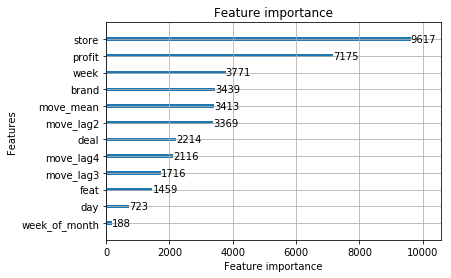

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

Sample MAPE is 32.28878395471111
Sample MAPE is 29.023120577530605
Sample MAPE is 28.074609800150423
Sample MAPE is 64.35562201046667
Sample MAPE is 60.24128800795966


<Figure size 432x288 with 0 Axes>

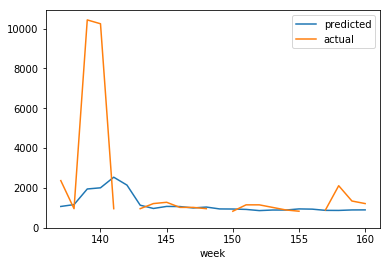

<Figure size 432x288 with 0 Axes>

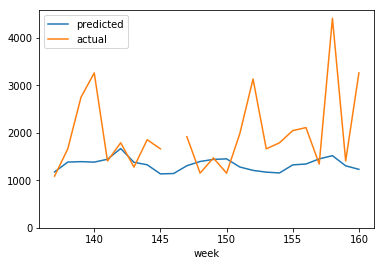

<Figure size 432x288 with 0 Axes>

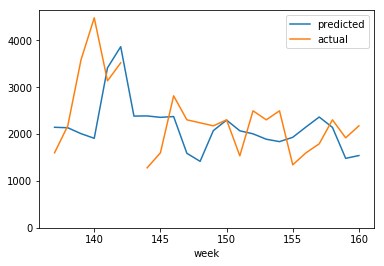

<Figure size 432x288 with 0 Axes>

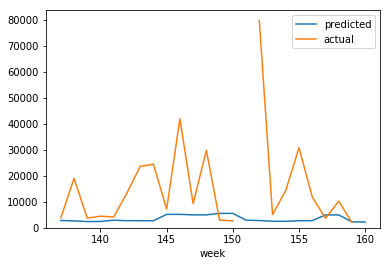

<Figure size 432x288 with 0 Axes>

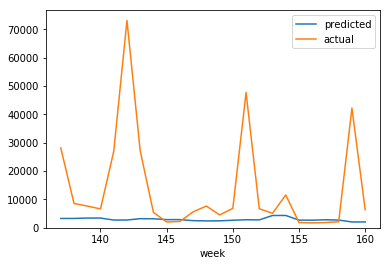

In [8]:
# Visualize forecast results
results = pd.concat(combined_all, axis=0)
for _ in range(5):
    store = random.choice(results['store'].unique())
    brand = random.choice(results['brand'].unique())
    plot_result(results, store, brand)